In [1]:
# Group number: 24
# Franka Buytenhuijs, s4356845
# Hugo Chateau-Laurent, s1023970
# Maria Tsfasman, s1021505

**SOW-MKI49: Neural Information Processing Systems**

**Assignment 5: Neural Decoding**

**Total points: 100**

**Author: Umut**

In this assignment, you will implement a neural decoder for reconstructing perceived stimuli from brain responses. We will be using the dataset that was previously used in a number of papers. These papers along with additional lecture notes on neural decoding can be found in Brightspace. You can refer them for more details on the dataset and/or the method.

The dataset contains fMRI data acquired from the early visual cortex of one subject as the subject was presented with 100 grayscale images of handwritten sixes and nines (50 sixes and 50 nines). The fMRI data has been realigned and slice time corrected. Furthermore, stimulus specific response amplitudes have been estimated with a general linear model.

Let's first familiarize ourselves with the dataset. It contains a number of variables:

* **X** -> This is a 100 x 784 matrix. The ith row contains the pixel values of the stimulus that was presented in the ith trial of the experiment. Note that the stimuli are 28 pixel x 28 pixel images, which were reshaped to 1 x 784 vectors.

* **Y** -> This is a 100 x 3092 matrix. The ith row contains the voxel values of the responses that were measured in the ith trial of the experiment.

* **X_prior** -> This is a 2000 x 784 matrix. Each row contains the pixel values of a different stimulus, which was not used in the experiment. Note that the stimuli are 28 pixel x 28 pixel images, which were reshaped to 1 x 784 vectors.

Note: In the remainder of this document, we will use **x** for referring to a 784 x 1 stimulus vector and **y** for referring to a 3092 x 1 response vector.

## Task 1 (10 points)

* Load the dataset.
* Visualize some of the stimuli.
* Normalize X and Y to have zero mean and unit variance. Tip: Recall that normalization means subtracting the mean of each pixel/voxel from itself and dividing it by its standard deviation. You can use zscore function.
* Split X and Y in two parts called X_training and X_test, and Y_training and Y_test. The training set should contain 80 stimulus-response pairs (40 pairs for sixes and 40 pairs for nines). The test set should contain 20 stimulus-response pairs (10 pairs for sixes and 10 pairs for nines).

In [1]:
gpu = False

if gpu:
    import cupy as np
else:
    import numpy as np
    
from scipy.io import loadmat
from scipy.stats import zscore

import scipy
import math
import matplotlib.pyplot as plt
import seaborn as sns


Keys in data:
  __header__
  __version__
  __globals__
  X
  X_prior
  Y
  anatomical
  region_of_interest_label
  region_of_interest_mask
  stimulus_label


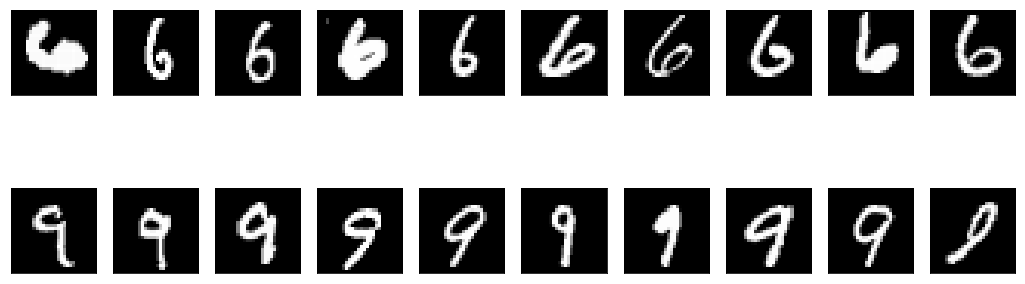

In [2]:
def prepare(arr):
    # prepare array to plot it the right way
    return np.flipud(np.rot90(arr.reshape(28,-1),1))


data = scipy.io.loadmat('69dataset2.mat')

X = zscore(data['X'], axis = None) # normalize X
Y = zscore(data['Y'], axis=None) #normalize Y
X_prior = zscore(data['X_prior'], axis=None) #normalize X_prior


# print all keys
print('Keys in data:')
for key in data:
    print('  '+key)

plt.figure(figsize=(18,6))
tot = 10
for i in range(tot):   
    
    #Plot 6
    plt.subplot(2,tot,1+i)    
    plt.imshow(prepare(X[i]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    #Plot 9
    plt.subplot(2,tot,1+i+tot)  
    plt.imshow(prepare(X[i+50]), cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.show()


X_training = np.concatenate((X[:40], X[50:90]))
X_test = np.concatenate((X[40:50], X[90:]))

Y_training = np.concatenate((Y[:40], Y[50:90]))
Y_test = np.concatenate((Y[40:50], Y[90:]))



##### Our goal is to solve the problem of reconstructing **x** from **y**. One possible approach to solve this problem is to use a *discriminative* model. Discriminative models predict **x** as a function of **y**. That is:

**x** = f(**y**)

We will assume that f is a linear function. That is:

**x** = **B'** **y**

f can be seen as a very simple linear neural network comprising one layer of weights (i.e., **B**). We can estimate **B** in close form with ridge regression. That is:

**B** = inv(**Y**\_training' **Y**\_training + lambda **I**) **Y**\_training' **X**\_training

where lambda is the regularization coefficient, **I** is the *q* x *q* identity matrix, and *q* is the number of voxels. Note that we can safely ignore the intercept since we normalized our data to have zero mean and unit variance.

## Task 2  (15 points)

* Estimate **B** on the training set. Tip: Normally, you should use cross validation to estimate lambda. For simplicity, you can assume that lambda = 10 ^ -6.
* Reconstruct **x** from **y** in the test set.
* Visualize the reconstructions.

(80, 3092)
(20, 784)


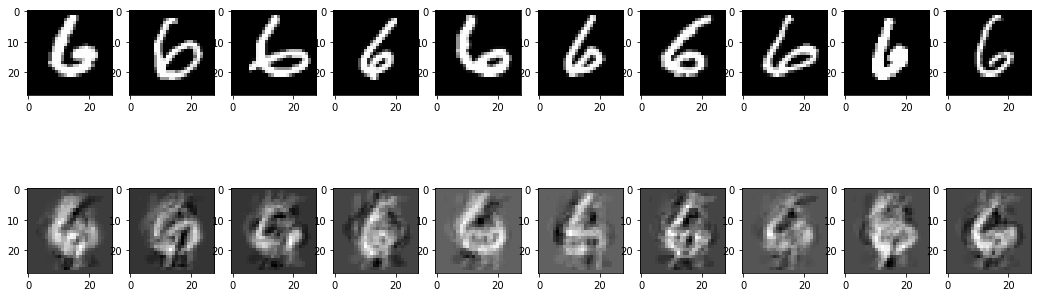

In [3]:
#Define q and lambda
q = np.size(Y_training, 1)
print(Y_training.shape)
lamb = math.pow(10,-6)

#Estimate B ont the training set
B_temp = np.linalg.inv(np.matmul(np.transpose(Y_training), Y_training) + lamb * np.identity(q)) 
B = np.matmul(np.matmul(B_temp, np.transpose(Y_training)), X_training)

#Reconstruct x from y in the test set.
X_reconstruct = np.matmul(Y_test, B)

print(X_reconstruct.shape)
#Visualize the reconstructions
plt.figure(figsize=(18,6))
tot = 10
for i in range(tot):   
    
    #Plot x_test
    plt.subplot(2,tot,1+i)    
    plt.imshow(prepare(X_test[i]), cmap='gray')
    
    #Plot x_reconstruct
    plt.subplot(2,tot,1+i+tot)  
    plt.imshow(prepare(X_reconstruct[i]), cmap='gray')
    
plt.show()


Another possible approach to solve the problem of reconstructing **x** from **y** is to use a *generative* model and invert it with Bayes' rule. We reformulate the problem as finding the most probable **x** that could have caused **y**. That is:

argmax_**x** P(**x** | **y**)

where P(**x** | **y**) is called the posterior (probability of the stimulus being **x** if the observation is **y**). In other words, we have to define the posterior, estimate its parameters and find the argument that maximizes it, which will be the reconstruction of **x** from **y**. While, this may seem daunting, it actually has a simple solution. The posterior assigns a probability to an event by combining our observations and beliefs about it, and can be decomposed with Bayes' rule as the product of how likely our observations are given the event (probability of observing **y** if the stimulus is **x**) and how likely the event is independent of our observations (probability of the stimulus being **x**). That is:

P(**x** | **y**) ~ P(**y** | **x**) * P(**x**)

where P(**y** | **x**) is called the likelihood and P(x) is called the prior.

We will assume that the likelihood and the prior are multivariate Gaussian distributions. A Gaussian is characterized by two parameters: a mean vector and a covariance matrix. In the case of the likelihood, the mean of the Gaussian is given by:

**mu**\_likelihood = **B'** **x**

As before, we can estimate **B** in close form with ridge regression:

**B** = inv(**X**\_training' **X**\_training + lambda **I**) **X**\_training' **Y**\_training

where lambda is the regularization coefficient, I is the *p* x *p* identity matrix, and *p* is the number of pixels. The covariance matrix of the likelihood is given by:

**Sigma**_likelihood = diag(E[||**y** - **B'** **x**|| ^ 2]). 

In the case of the prior, the mean of the Gaussian is given by:

**mu**\_prior = **0** (which is a vector of zeros)

The covariance matrix of the prior is given by:

**Sigma**\_prior = **X**\_prior' * **X**\_prior / (n - 1)

where n is the length of **X**\_prior.

## Task 3 (20 points)

* Estimate **B** on the training set. Tip: Normally, you should use cross-validation to estimate lambda and Sigma_likelihood. For simplicity, you can assume that lambda = 10 ^ -6 and Sigma_likelihood = 10 ^ -3 **I**.
* Estimate **Sigma**\_prior. Tip: Add 10 ^ -6 to the diagonal of Sigma_prior for regularization.
* Visualize **Sigma**\_prior. Can you explain what it shows?

(80, 784)
784
(784, 784)
(784, 3092)
(784, 784)


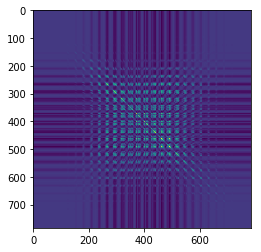

In [4]:
#Define lamda, sigma and q
p = np.size(X_training, 1)
print(X_training.shape)
print(p)
lamb = math.pow(10,-6)
sigma_like = math.pow(10, -3) * np.identity(p)
print(sigma_like.shape)


#Estimate B on the training set
#B = inv(X_training' X_training + lambda I) X_training' Y_training
B_temp = np.linalg.inv(np.matmul(np.transpose(X_training), X_training) + lamb * np.identity(p)) 
B = np.matmul(np.matmul(B_temp, np.transpose(X_training)), Y_training)
print(B.shape)

#Estimate sigma_prior
n = np.size(X_prior)
sigma_prior = np.matmul(np.transpose(X_prior), X_prior) / (n-1)
sigma_prior_reg = sigma_prior + lamb * np.identity(p)
print(sigma_prior_reg.shape)

plt.imshow(sigma_prior_reg)
plt.show()

#Explain what sigma_prior shows
#TODO

Having defined the likelihood and the prior as Gaussians, we can derive the posterior by multiplying them. It turns out that the product of two Gaussians is another Gaussian, whose mean vector is given by:

**mu**\_posterior = inv(inv(**Sigma**\_prior) + **B** inv(**Sigma**\_likelihood) **B**') **B** * inv(**Sigma**\_likelihood) **y**

We are almost done. Recall that the reconstruction of **x** from **y** is the argument that maximizes the posterior, which we derived to be a Gaussian. We will be completely done once we answer the following question: What is the argument that maximizes a Gaussian?

.  
.  
.  
.  
.  
.

The answer is its mean vector, which is the solution of our initial problem. That is:

argmax_**x** P(**x** | **y**) =  
**mu**\_posterior =  
inv(inv(**Sigma**\_prior) + **B** inv(**Sigma**\_likelihood) **B**') **B** * inv(**Sigma**\_likelihood) **y**

Now, we can plug any **y** in the above equation and reconstruct the most probable **x** that could have caused it.


## Task 4 (25 points)

- Reconstruct **x** from **y** in the test set.
- Visualize the reconstructions.
- Compare the reconstructions with the earlier reconstructions. Which one is better? Why? Can you think of ways to improve the results?

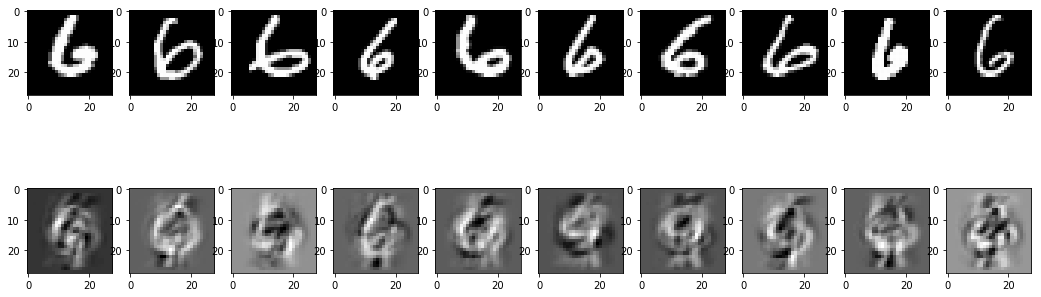

In [5]:
#Reconstruct x from y in the test set.
#mu_posterior = inv(inv(Sigma_prior) + B inv(Sigma_likelihood) B') B inv(Sigma_likelihood) *y
#had some problems with matrix dimensions here. Could not exactly do what is described above

X_test_reconstructed_temp = np.linalg.inv(np.linalg.inv(sigma_prior_reg) + np.matmul(np.matmul(np.linalg.inv(sigma_like), B), np.transpose(B)))
X_test_reconstructed = np.matmul(np.transpose(np.matmul(np.matmul(X_test_reconstructed_temp, B).T, np.linalg.inv(sigma_like))), np.transpose(Y_test))
X_test_reconstructed_trans = np.transpose(X_test_reconstructed)

plt.figure(figsize=(18,6))
tot = 10
for i in range(tot):   
    
    #Plot x_test
    plt.subplot(2,tot,1+i)    
    plt.imshow(prepare(X_test[i]), cmap='gray')
    
    #Plot x_reconstruct
    plt.subplot(2,tot,1+i+tot)  
    plt.imshow(prepare(X_test_reconstructed_trans[i]), cmap='gray')
    
plt.show()

Now the real fight begins! You might have already realized that the second approach is very similar to the one in the face reconstruction paper that we have discussed in the last lecture. The main difference is how the stimuli are encoded. So far, we have been encoding the stimuli with an identity transformation:

**mu**\_likelihood = **B'** g(**x**)

where g(**x**) = **x**

In the paper, they are encoded as the features extracted from a DNN:

**mu**\_likelihood = **B'** DNN(**x**)

Similarly, we have been decoding the responses with MAP estimation of the stimuli:

g ^ -1(argmax_g(**x**) P(g(**x**) | **y**))

where g ^ -1(**y**) = **y**

In the paper, they are decoded with MAP estimation of the features followed by an inverse DNN:

DNN ^ -1(argmax_DNN(**x**) P(DNN(**x**) | **y**))

## Task 5 (30 points)

- Train a simple DNN for digit classification on the MNIST dataset.
- Select an indermediate layer of the DNN as your feature extractor.
- Train another simple DNN to invert the first DNN. That is, it should transform features extracted by the selected layer of the first DNN to stimuli.
- Repeat Task 3 but use the trained DNNs instead of identity transformation.

In [0]:
###